In [1]:
# 443901, m.joo@wustl.edu, Joo, Michael
# 472926, michael.kincheloe@wustl.edu, Kincheloe, Michael
# 457870, jfeibelman@wustl.edu, Feibelman, Jason
# 463959, m.fishman@wustl.edu, Fishman, Matthew 
# 458013, mattwitzerman@wustl.edu, Witzerman, Matt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
# train = pd.read_csv('/kaggle/input/suspicious-transaction-detection/train.csv')
# test = pd.read_csv('/kaggle/input/suspicious-transaction-detection/test.csv')

train = pd.read_csv('../suspicious-transaction-detection/train.csv')

N_train, dim = train.shape
# N_test, _ = test.shape

X_train = train.drop(['Target'], axis=1)
y_train = train['Target'].copy()

In [4]:
N_train

472432

In [5]:
med_features = np.concatenate((['Amount'],
                               ['T_{}'.format(t) for t in range(15)], 
                               ['C_{}'.format(c) for c in range(9, 23)],
                               ['C_26', 'C_27', 'C_28'], 
                               ['V_{}'.format(v) for v in range(339)], 
                               ['O_0', 'O_1', 'O_5', 'O_6', 'O_9', 'O_18', 'O_31', 'O_36'],
                               ['A_0', 'M_1']
                              ))
mod_features = np.concatenate((['C_0', 'C_1', 'C_2', 'C_3', 'C_4', 'C_6', 'C_7', 'C_8', 'C_23'],
                               ['O_2', 'O_3', 'O_10', 'O_11', 'O_12', 'O_15', 'O_20', 'O_21', 'O_22', 'O_24', 'O_26', 'O_27', 'O_28', 'O_29', 'O_30', 'O_32', 'O_33', 'O_34', 'O_35', 'O_37', 'O_38'],
                               ['A_1']
                              ))
oh_features = np.concatenate((['Goods', 'C_5', 'C_24', 'C_25'],
                              ['O_4', 'O_7', 'O_8', 'browser', 'O_16', 'O_17', 'os', 'O_23', 'O_25',  'O_39'],
                              ['E_same', 'M_0']
                             ))

print(len(med_features) + len(mod_features) + len(oh_features))

429


In [6]:
# features = pd.concat([X_train, test]).reset_index(drop=True)
features = X_train.copy()

features = features.drop(['TransactionID', 'Timestamp', 'O_14'], axis=1)

features['browser'] = features['O_13'].str.split(' ').str[0]
features['os'] = features['O_19'].str.split(' ').str[0]
features['E_0'] = features['E_0'].fillna('empty')
features['E_same'] = np.where(features['E_0'] == features['E_1'], 'T', 'F')

features = features.drop(['O_13', 'O_19', 'E_0', 'E_1'], axis=1)

for feature in med_features:
    med = X_train[feature].median()
    features[feature] = features[feature].fillna(med)
for feature in mod_features:
    mod = X_train[feature].mode()[0]
    #print('{}: {}'.format(feature, mod))
    features[feature] = features[feature].fillna(mod)

features_prepared = pd.get_dummies(features, columns=oh_features)

features_prepared.replace('T', 1, inplace=True)
features_prepared.replace('F', 0, inplace=True)

X_train_prepared = features_prepared.iloc[:N_train, :].copy()
# X_test_prepared = features_prepared.iloc[N_train:, :].copy()

X_num = X_train_prepared[med_features]

print(X_train_prepared.shape)
print(X_num.shape)
# print(X_test_prepared.shape)

(472432, 497)
(472432, 382)


In [7]:
# After the data filling we perform PCA
from sklearn.decomposition import PCA
from sklearn import preprocessing

# min_max_scaler = preprocessing.MinMaxScaler()
standard = preprocessing.StandardScaler()
X_train_standard = standard.fit_transform(X_num)
# X_train_minmax = min_max_scaler.fit_transform(X_train_standard)

pca = PCA(n_components=3)
pc = pca.fit_transform(X_train_standard)
print(pc.shape)

(472432, 3)


(472432,)
(472432,)


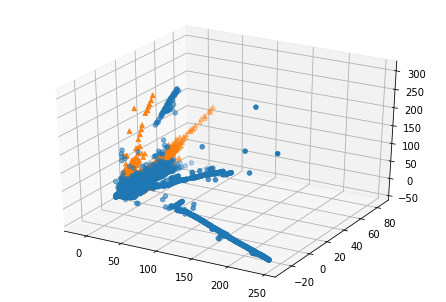

In [8]:
# fig = plt.figure()
# ax = plt.Axes3D(fig)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 

inds = np.random.choice(N_train, size=100000, replace=False)
pc1 = pc[:, 0]
pc2 = pc[:, 1]
pc3 = pc[:, 2]
ys = y_train[:]

fig = plt.figure()
print(pc[:,0].shape)
print(y_train.shape)

ax = Axes3D(fig)
ix = np.where(ys == 0)
ax.scatter(pc1[ix], pc2[ix], pc3[ix], marker = 'o')
ix = np.where(ys == 1)
ax.scatter(pc1[ix], pc2[ix], pc3[ix], marker = '^')


With the data prepared, we train a Random Forest classifier model on the training data. To evaluate the model, we apply 5-fold cross validation and observe the mean and standard deviation of the accuracy of our model.

In [9]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score

# forest = RandomForestClassifier()
# forest_error = cross_val_score(forest, X_train_prepared, y_train, cv=5)
# print(forest_error.mean())
# print(forest_error.std())

In [16]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


def split_xy(df):
    y = df['Target']
    x = df.drop('Target',axis=1)
    return x,y

standard = preprocessing.StandardScaler()
X_train_standard = standard.fit_transform(X_train_prepared)
pca = PCA(n_components=10)
pc = pca.fit_transform(X_train_standard)

xTr, xTe, yTr, yTe = train_test_split(pc, y_train, test_size=0.10, random_state=50)
print(pc.shape)
print(xTr.shape)
print(xTe.shape)
# validation_data = features_prepared.sample(frac=.1)
# pre_train_data = features_prepared.drop(validation_data.index).reset_index(drop=True)
# xTr, yTr = split_xy(pre_train_data)
# xTe, yTe = split_xy(validation_data)


(472432, 10)
(425188, 10)
(47244, 10)


In [ ]:
# clf_knn = KNeighborsClassifier(n_neighbors=5)
# clf_knn.fit(xTr, yTr)
# preds_knn = clf_knn.predict_proba(xTe)
# roc_knn = roc_auc_score(yTe,preds_knn[:,1])
# print("KNN AUC : %s" % (roc_knn))

# cv = KFold(n_splits=2, random_state=1, shuffle=True).split(pre_train_data)
grid = {}
grid['knn'] = {'p':[1,2], 'n_neighbors':[1,3,5,7,9]}
grid['rf'] = {'n_estimators': [10,50], 'max_depth':[None,2,4,6]}
grid['svmg'] = {'kernel':['rbf'],'gamma':['auto'],'C':[.01,.1,.5,1], 'tol':[1e-1,1e-2,1e-3,1e-4]}

clf_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=grid['knn'], n_jobs=-1)
clf_knn.fit(xTr, yTr)
preds_knn = clf_knn.predict_proba(xTe)
roc_knn = roc_auc_score(yTe,preds_knn[:,1])
print("KNN AUC : %s - %s" % (roc_knn,clf_knn.best_params_))

The results seem promising. Note that a Random Forest model, by default, returns the predicted label of a data point. Since we want the probability of a transaction being fraudulent instead of its predicted label, we return the number of votes that believe a transaction is fraudulent divided by the total number of votes from the Random Forest model. 

In [ ]:
# forest.fit(X_train_prepared, y_train)
# y_pred = forest.predict_proba(X_test_prepared)
# my_submission = pd.DataFrame({'TransactionID': test.TransactionID, 'Target': y_pred[:, 1]})
# my_submission.to_csv('submission.csv', index=False)

forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid['svmg'], n_jobs=-1, cv=cv)
forest.fit(xTr,yTr)
preds_forest = forest.predict_proba(xTe)
roc_forest = roc_auc_score(yTe,preds_forest[:,1])
print("RF AUC : %s - %s" % (roc_forest,forest.best_params_))

In [ ]:

clf_svmg = GridSearchCV(estimator=svm.SVC(), param_grid=grid['svmg'], n_jobs=-1, cv=cv)
clf_svmg.fit(xTr, yTr)
preds_svmg = clf_svmg.predict_proba(xTe)
roc_svmg = roc_auc_score(yTe,preds_svmg[:,1])
print("SVM[G] AUC : %s - %s" % (roc_svmg,clf_svmg.best_params_))